# Analyze

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

plt.rcParams["font.family"] = "UGent Panno Text"
plt.rcParams["font.size"] = 28

import tools.common_functions as cf
import tools.plotting_functions as pf

# Parameters
SENSOR_LAG = 25 # ms
ARRAY_W = 4
ARRAY_H = 8
ARRAY_SIZE = ARRAY_W * ARRAY_H

TAXEL_ID = 0

NAME = f"table_calibration/taxel{TAXEL_ID}"


In [5]:
original_data = cf.prepare_data_for_fitting(NAME, ARRAY_SIZE, SENSOR_LAG, rotation=90 + 1.82, faulty=False, cut_in_half=False)
# original_data = cf.prepare_data_for_fitting(NAME, ARRAY_SIZE, SENSOR_LAG, rotation=90 - 1.82, faulty=False, cut_in_half=False)
# original_data['F_x'] *= -1

Preparing data for fitting: table_calibration/taxel0


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:311: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


/tmp/ipykernel_17777/2494396572.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  axs[0].plot(t, original_data['Z0'][mindex:maxdex])
/tmp/ipykernel_17777/2494396572.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  axs[1].plot(t, original_data['F_z'][mindex:maxdex])
/tmp/ipykernel_17777/2494396572.py:14: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with 

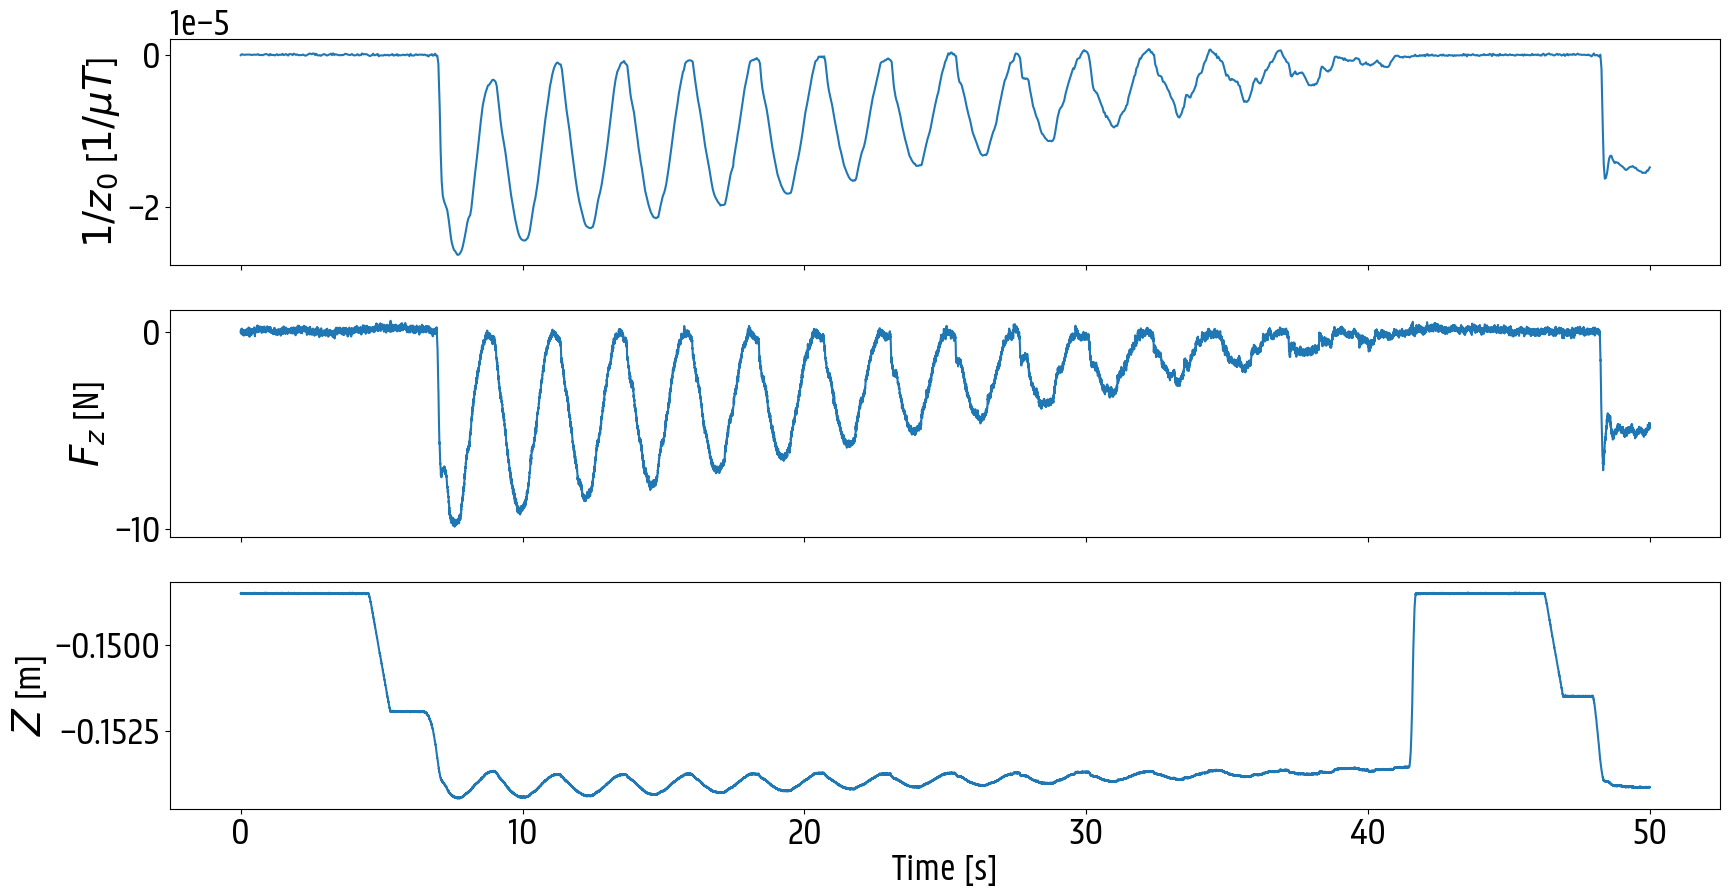

In [34]:
mindex = 0
maxdex = 20000

fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)

t = np.arange(mindex, maxdex) / 400 # 400 Hz

axs[0].plot(t, original_data['Z0'][mindex:maxdex])
axs[0].set_ylabel(f'$1/z_0$ [$1/\mu T$]')

axs[1].plot(t, original_data['F_z'][mindex:maxdex])
axs[1].set_ylabel(f'$F_z$ [N]')

axs[2].plot(t, original_data['Z'][mindex:maxdex])
axs[2].set_ylabel(f'$Z$ [m]')

axs[2].set_xlabel('Time [s]')

plt.savefig("plots/c3_3hz.pdf", format="pdf", bbox_inches="tight")

In [88]:
import os
import dill
    
save_path = os.path.join(os.getcwd(), '..', 'models', "4x8")
with open(os.path.join(save_path, f"stageII"), 'rb') as f:
    stage_II_model = dill.load(f)     
with open(os.path.join(save_path, f"stageI"), 'rb') as f:
    stage_I_model = dill.load(f)  
with open(os.path.join(save_path, f"stageI_alt"), 'rb') as f:
    stage_I_alt_model = dill.load(f)        

In [89]:
forces = stage_I_model.predict(original_data)
forces_alt = stage_I_alt_model.predict(original_data)

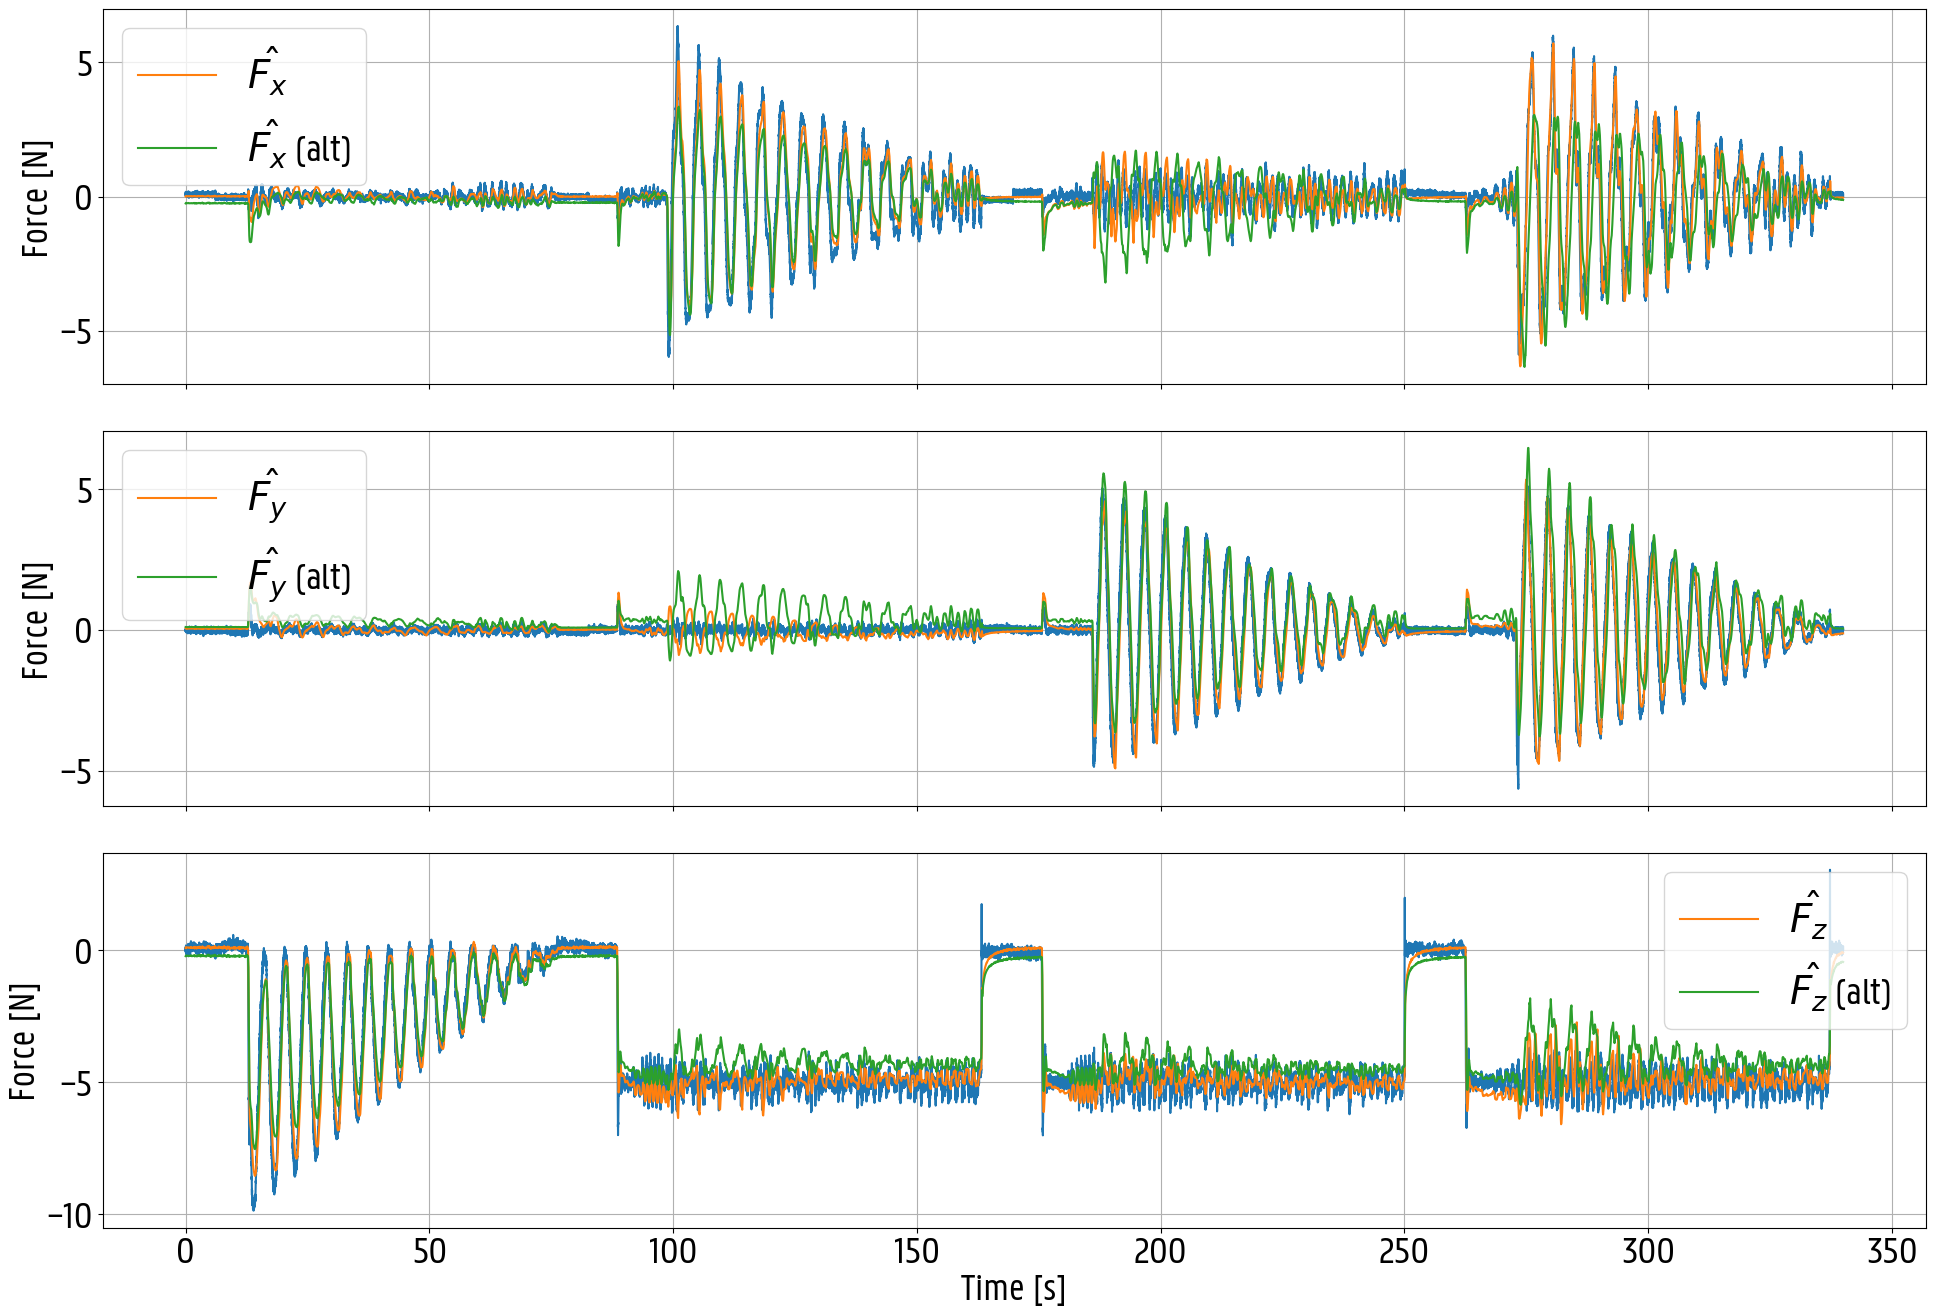

In [91]:
# Extract prediction data
columns = [f'X{TAXEL_ID}', f'Y{TAXEL_ID}', f'Z{TAXEL_ID}']


# Create subplots
fig, ax = plt.subplots(3, 1, figsize=(20, 15), sharex=True, sharey=False)

# Define common labels and titles
axes_labels = ['$F_x$', '$F_y$', '$F_z$']
axes_vals = ['F_x', 'F_y', 'F_z']
pred_labels = ['$\hat{F_x}$', '$\hat{F_y}$', '$\hat{F_z}$']
titles = ['X-axis Force Prediction', 'Y-axis Force Prediction', 'Z-axis Force Prediction']
colors = ['r', 'g', 'b']

t = np.linspace(0, int(340), len(original_data))

for i, axi in enumerate(ax):
    axi.plot(t, original_data[axes_vals[i]])
    
    Y_pred = forces[0]
    axi.plot(t, Y_pred[:, i], label=pred_labels[i])
    
    Y_pred = forces_alt[0]
    axi.plot(t, forces_alt[0][:, i], label=pred_labels[i] + " (alt)")
    
    axi.set_ylabel('Force [N]')
    # axi.set_title(titles[i])
    axi.legend()
    axi.grid(True)

# Set common x-label for the entire figure
ax[-1].set_xlabel('Time [s]')
# ax[-1].set_xlim([0, 50])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.savefig("plots/c4_stageI_fit_cv.pdf", format="pdf", bbox_inches="tight")
plt.show()

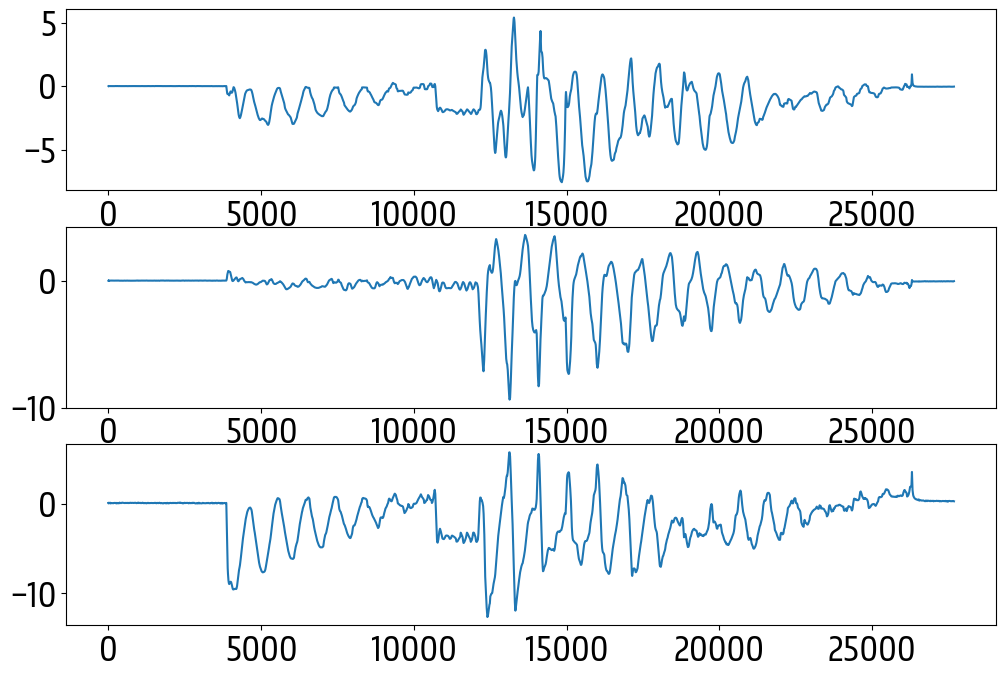

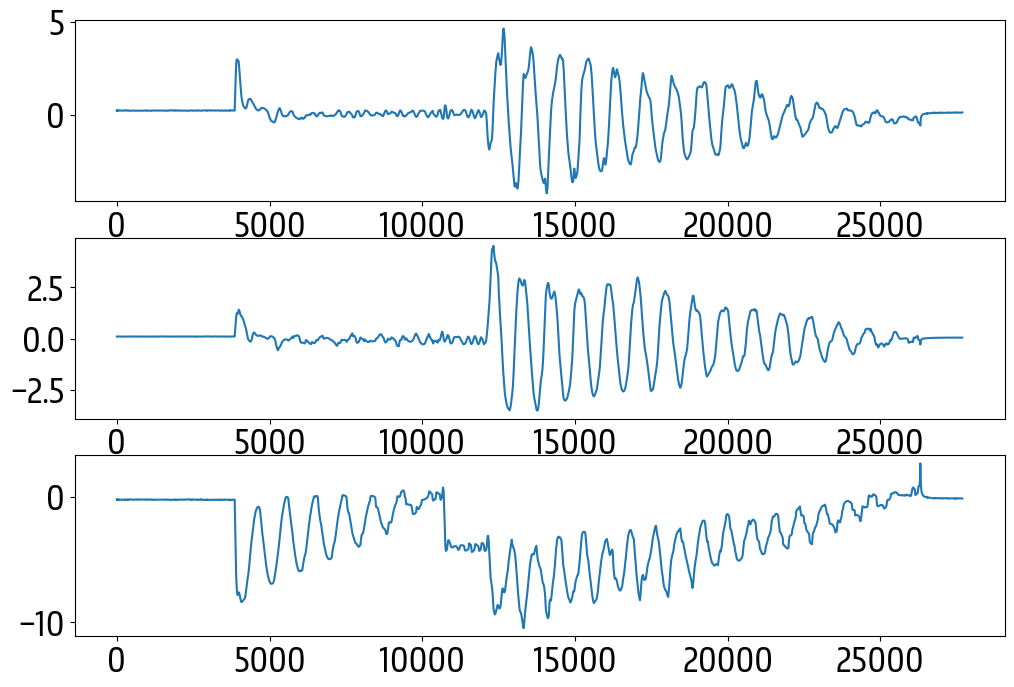

In [44]:
pf.plot_three_components(forces[TAXEL_ID].T)
pf.plot_three_components(forces_alt[TAXEL_ID].T)

/tmp/ipykernel_7754/1842955071.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(original_data["Z"][78000:92000])


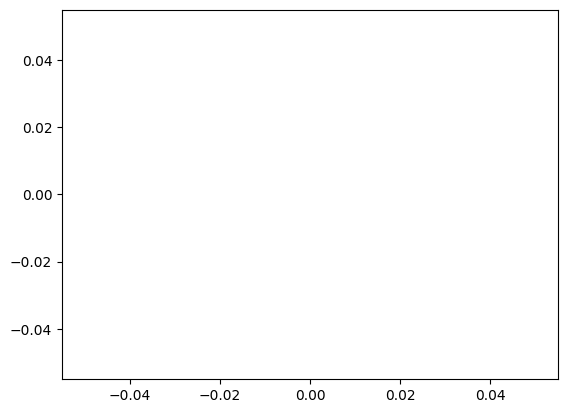

In [58]:
plt.plot(original_data["Z"][78000:92000])

/tmp/ipykernel_54453/3434382354.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(original_data["F_z"][78000:92000])


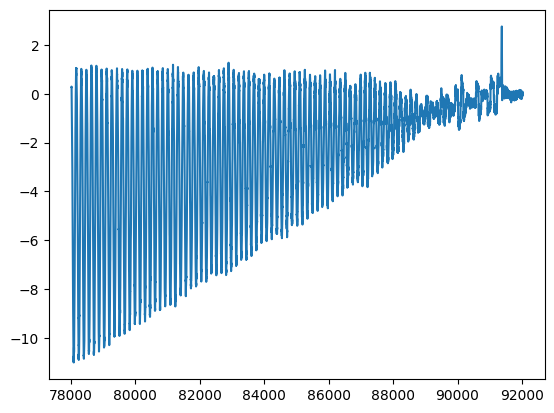

In [15]:
plt.plot(original_data["F_z"][78000:92000])

/tmp/ipykernel_60551/282070990.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(original_data["Z28"][0:18000], original_data["F_z"][0:18000])


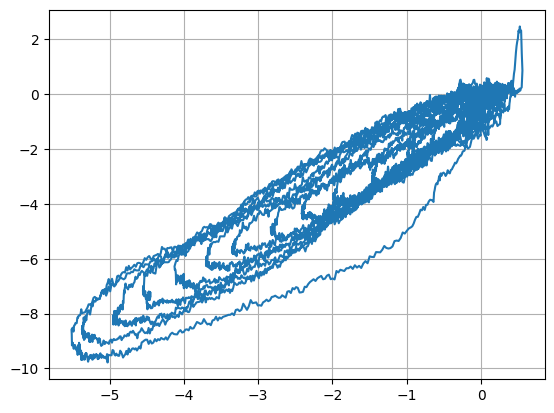

In [9]:
plt.plot(original_data["Z28"][0:18000], original_data["F_z"][0:18000])
plt.grid()
# plt.plot(original_data["Z28"][75000:90000], original_data["F_z"][75000:90000])
# plt.plot(original_data["Z28"][18000:25000], original_data["F_z"][18000:25000])

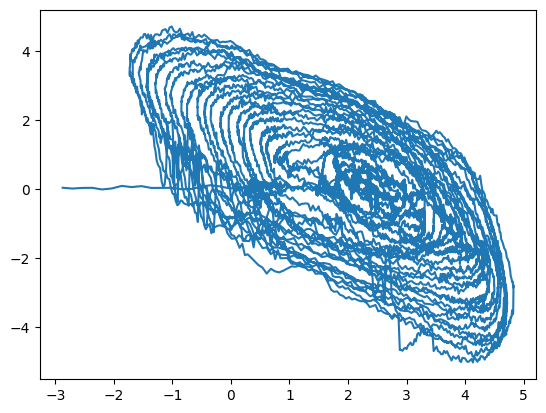

In [38]:
plt.plot(original_data["X28"], original_data["F_y"])

/tmp/ipykernel_60193/374818657.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(original_data["Z28"][30000:40000], original_data["F_z"][30000:40000])


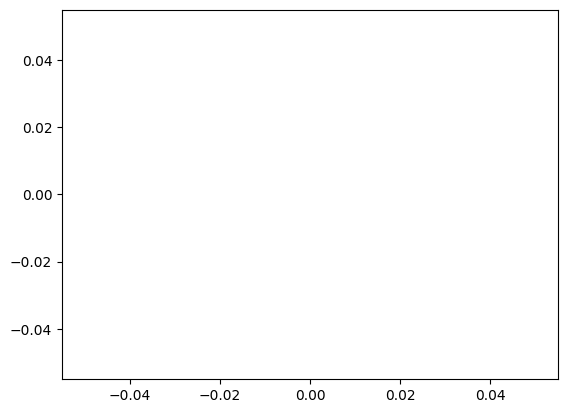

In [35]:
plt.plot(original_data["Z28"][30000:40000], original_data["F_z"][30000:40000])